<a href="https://colab.research.google.com/github/maggieliuzzi/reinforcement_learning/blob/master/monte_carlo/control/OnPolicy_FirstVisit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Monte Carlo** | Control Problem | On-Policy, First Visit

Finding optimal policy

- Policy: probabilistic (uniform random)

In [0]:
from __future__ import print_function, division
from builtins import range
import matplotlib.pyplot as plt
import numpy as np
!wget "https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/rl/grid_world.py"
from grid_world import standard_grid, negative_grid
!wget "https://raw.githubusercontent.com/maggieliuzzi/reinforcement_learning/master/environments/utils.py"
from utils import print_values, print_policy

In [0]:
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

In [0]:
def random_action(a, eps=0.1):
  # choose given a with probability 1 - eps + eps/4
  # choose some other a' != a with probability eps/4
  p = np.random.random()
  # if p < (1 - eps + eps/len(ALL_POSSIBLE_ACTIONS)):
  #   return a
  # else:
  #   tmp = list(ALL_POSSIBLE_ACTIONS)
  #   tmp.remove(a)
  #   return np.random.choice(tmp)
  #
  # this is equivalent to the above
  if p < (1 - eps):
    return a
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)

In [0]:
def play_game(grid, policy):
  # returns a list of states and corresponding returns
  # in this version we will NOT use "exploring starts" method
  # instead we will explore using an epsilon-soft policy
  s = (2, 0)
  grid.set_state(s)
  a = random_action(policy[s])

  # be aware of the timing
  # each triple is s(t), a(t), r(t)
  # but r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
  states_actions_rewards = [(s, a, 0)]
  while True:
    r = grid.move(a)
    s = grid.current_state()
    if grid.game_over():
      states_actions_rewards.append((s, None, r))
      break
    else:
      a = random_action(policy[s]) # the next state is stochastic
      states_actions_rewards.append((s, a, r))

  # calculate the returns by working backwards from the terminal state
  G = 0
  states_actions_returns = []
  first = True
  for s, a, r in reversed(states_actions_rewards):
    # the value of the terminal state is 0 by definition
    # we should ignore the first state we encounter
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_actions_returns.append((s, a, G))
    G = r + GAMMA*G
  states_actions_returns.reverse() # we want it to be in order of state visited
  
  return states_actions_returns

In [5]:
grid = negative_grid(step_cost=-0.1)

print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|


In [0]:
# state -> action
# initialize a random policy
policy = {}
for s in grid.actions.keys():
  policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

# initialize Q(s,a) and returns
Q = {}
returns = {} # dictionary of state -> list of returns we've received
states = grid.all_states()
for s in states:
  if s in grid.actions: # not a terminal state
    Q[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
      Q[s][a] = 0
      returns[(s,a)] = []
  else:
    # terminal state or state we can't otherwise get to
    pass

In [0]:
def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  max_key = None
  max_val = float('-inf')
  for k, v in d.items():
    if v > max_val:
      max_val = v
      max_key = k
  return max_key, max_val

In [10]:
# repeat until convergence
deltas = []
for t in range(5000):
  if t % 1000 == 0:
    print(t)

  # generate an episode using pi
  biggest_change = 0
  states_actions_returns = play_game(grid, policy)

  # calculate Q(s,a)
  seen_state_action_pairs = set()
  for s, a, G in states_actions_returns:
    # check if we have already seen s
    # called "first-visit" MC policy evaluation
    sa = (s, a)
    if sa not in seen_state_action_pairs:
      old_q = Q[s][a]
      returns[sa].append(G)
      Q[s][a] = np.mean(returns[sa])
      biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
      seen_state_action_pairs.add(sa)
  deltas.append(biggest_change)

  # calculate new policy pi(s) = argmax[a]{ Q(s,a) }
  for s in policy.keys():
    a, _ = max_dict(Q[s])
    policy[s] = a

0
1000
2000
3000
4000


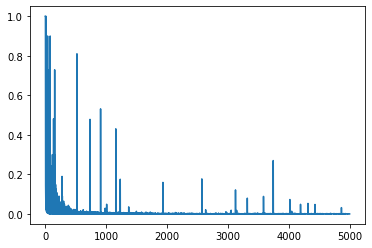

In [13]:
plt.plot(deltas)
plt.show()

In [0]:
# find the optimal state-value function
# V(s) = max[a]{ Q(s,a) }
V = {}
for s in policy.keys():
  V[s] = max_dict(Q[s])[1]

In [15]:
print("final values:")
print_values(V, grid)
print("final policy:")
print_policy(policy, grid)

final values:
---------------------------
 0.58| 0.77| 1.00| 0.00|
---------------------------
 0.41| 0.00| 0.74| 0.00|
---------------------------
 0.25| 0.12| 0.05| 0.00|
final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  L  |  L  |  L  |
